# Import libraries and load IMDB Reviews dataset

In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from collections import Counter
import re
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import numpy as np

In [2]:
def read_imdb_split(split_dir, max_per_class=None, val_split=0.1, random_seed=42):
    texts, labels = [], []
    for label in ['pos', 'neg']:
        labeled_dir = os.path.join(split_dir, label)
        files = os.listdir(labeled_dir)
        if max_per_class:
            files = files[:max_per_class]
        for fname in files:
            with open(os.path.join(labeled_dir, fname), encoding="utf-8") as f:
                texts.append(f.read())
                labels.append(1 if label == 'pos' else 0)
    
    # Convert to numpy arrays for easier shuffling
    texts = np.array(texts)
    labels = np.array(labels)
    
    # Shuffle the data
    np.random.seed(random_seed)
    indices = np.random.permutation(len(texts))
    texts = texts[indices]
    labels = labels[indices]
    
    if split_dir.endswith('train'):
        # Calculate split index
        split_idx = int(len(texts) * (1 - val_split))
        
        # Split into train and validation
        train_texts, val_texts = texts[:split_idx], texts[split_idx:]
        train_labels, val_labels = labels[:split_idx], labels[split_idx:]
        
        return train_texts.tolist(), train_labels.tolist(), val_texts.tolist(), val_labels.tolist()
    else:
        # For test set, return as is
        return texts.tolist(), labels.tolist()

In [3]:
# Load data with train/val split
train_texts, train_labels, val_texts, val_labels = read_imdb_split('aclImdb/train')
test_texts, test_labels = read_imdb_split('aclImdb/test')

In [4]:
# 2. Tokenization and vocab
def tokenize(text):
    return re.findall(r"\b\w+\b", text.lower())

counter = Counter()
for t in train_texts:
    counter.update(tokenize(t))
vocab = {w: i+2 for i, (w, _) in enumerate(counter.most_common())}  # 0: PAD, 1: UNK
vocab["<PAD>"] = 0
vocab["<UNK>"] = 1

def encode(text):
    return torch.tensor([vocab.get(w, 1) for w in tokenize(text)], dtype=torch.long)

In [5]:
# 3. Dataset and DataLoader
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def collate_fn(batch):
    X, y = zip(*batch)
    lengths = torch.tensor([len(x) for x in X])
    X_pad = pad_sequence(X, batch_first=True, padding_value=0)
    return X_pad, torch.tensor(y), lengths



In [6]:
X_train = [encode(t) for t in train_texts]
X_val = [encode(t) for t in val_texts]
X_test = [encode(t) for t in test_texts]
y_train = torch.tensor(train_labels)
y_val = torch.tensor(val_labels)
y_test = torch.tensor(test_labels)

# Create datasets
train_ds = TextDataset(X_train, y_train)
val_ds = TextDataset(X_val, y_val)
test_ds = TextDataset(X_test, y_test)
batch_size = 64
# Create dataloaders
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [7]:
print(f'len train : {len(y_train)}')
print(f'len val : {len(y_val)}')
print(f'len test : {len(y_test)}')


len train : 22500
len val : 2500
len test : 25000


In [8]:
epochs = 1

In [9]:
import time

history = {
    'train_loss': [],
    'val_loss': [],
    'val_accuracy': [],
    'epoch_time': [],
    'test_loss': None,
    'test_accuracy': None,
    'total_time': None
}
all_histories = {}

# CNN LSTM n Fully Connected layer

In [10]:
import torch.nn as nn
class CNNLSTMTextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.conv = nn.Conv1d(embed_dim, 128, kernel_size=3, padding=1)
        self.lstm = nn.LSTM(128, 128, batch_first=True)
        self.fc = nn.Linear(128, num_classes)
    def forward(self, x, lengths):
        x = self.embedding(x)              # [B, T, E]
        x = x.transpose(1, 2)              # [B, E, T]
        x = torch.relu(self.conv(x))       # [B, 128, T]
        x = x.transpose(1, 2)              # [B, T, 128]
        packed = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, (h, c) = self.lstm(packed)
        out = h[-1]                        # [B, 128]
        return self.fc(out)                # [B, num_classes]

model_name = 'CNNLSTM'
model = CNNLSTMTextClassifier(len(vocab), 100, 2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
history = {'train_loss': [], 'val_loss': [], 'val_accuracy': [], 'epoch_time': [], 'test_loss': None, 'test_accuracy': None, 'total_time': None}
start_total = time.time()
for epoch in range(epochs):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    start_time = time.time()
    for X_batch, y_batch, lengths in train_loader:
        X_batch, y_batch, lengths = X_batch.to(device), y_batch.to(device), lengths.to(device)
        optimizer.zero_grad()
        logits = model(X_batch, lengths)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        total_correct += (preds == y_batch).sum().item()
        total_samples += y_batch.size(0)
    avg_loss = total_loss / len(train_loader)
    accuracy = total_correct / total_samples * 100
    history['train_loss'].append(avg_loss)
    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for X_batch, y_batch, lengths in val_loader:
            X_batch, y_batch, lengths = X_batch.to(device), y_batch.to(device), lengths.to(device)
            logits = model(X_batch, lengths)
            loss = criterion(logits, y_batch)
            val_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            val_correct += (preds == y_batch).sum().item()
            val_total += y_batch.size(0)
    val_loss /= len(val_loader)
    val_accuracy = val_correct / val_total
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_accuracy)
    epoch_time = time.time() - start_time
    history['epoch_time'].append(epoch_time)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy*100:.2f}%, Time: {epoch_time:.2f}s")
history['total_time'] = time.time() - start_total
# Test evaluation
model.eval()
test_loss = 0
test_correct = 0
test_total = 0
with torch.no_grad():
    for X_batch, y_batch, lengths in test_loader:
        X_batch, y_batch, lengths = X_batch.to(device), y_batch.to(device), lengths.to(device)
        logits = model(X_batch, lengths)
        loss = criterion(logits, y_batch)
        test_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        test_correct += (preds == y_batch).sum().item()
        test_total += y_batch.size(0)
test_loss /= len(test_loader)
test_accuracy = test_correct / test_total
history['test_loss'] = test_loss
history['test_accuracy'] = test_accuracy
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy*100:.2f}%")
all_histories[model_name] = history
torch.save(model.state_dict(), '{model_name}.pth')

Epoch 1, Loss: 0.6041, Val Loss: 0.5340, Val Acc: 73.96%, Time: 47.01s
Test Loss: 0.5153, Test Accuracy: 75.29%


# LSTM

In [11]:

# Pure LSTM model for text classification
import torch.nn as nn

class PureLSTMTextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, 128, batch_first=True)
        self.fc = nn.Linear(128, num_classes)
    def forward(self, x, lengths):
        x = self.embedding(x)  # [B, T, E]
        packed = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, (h, c) = self.lstm(packed)
        out = h[-1]  # [B, 128]
        return self.fc(out)

model_name='PureLSTM'
model = PureLSTMTextClassifier(len(vocab), 100, 2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
history = {'train_loss': [], 'val_loss': [], 'val_accuracy': [], 'epoch_time': [], 'test_loss': None, 'test_accuracy': None, 'total_time': None}
start_total = time.time()
for epoch in range(epochs):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    start_time = time.time()
    for X_batch, y_batch, lengths in train_loader:
        X_batch, y_batch, lengths = X_batch.to(device), y_batch.to(device), lengths.to(device)
        optimizer.zero_grad()
        logits = model(X_batch, lengths)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        total_correct += (preds == y_batch).sum().item()
        total_samples += y_batch.size(0)
    avg_loss = total_loss / len(train_loader)
    accuracy = total_correct / total_samples * 100
    history['train_loss'].append(avg_loss)
    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for X_batch, y_batch, lengths in val_loader:
            X_batch, y_batch, lengths = X_batch.to(device), y_batch.to(device), lengths.to(device)
            logits = model(X_batch, lengths)
            loss = criterion(logits, y_batch)
            val_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            val_correct += (preds == y_batch).sum().item()
            val_total += y_batch.size(0)
    val_loss /= len(val_loader)
    val_accuracy = val_correct / val_total
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_accuracy)
    epoch_time = time.time() - start_time
    history['epoch_time'].append(epoch_time)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy*100:.2f}%, Time: {epoch_time:.2f}s")
history['total_time'] = time.time() - start_total
# Test evaluation
model.eval()
test_loss = 0
test_correct = 0
test_total = 0
with torch.no_grad():
    for X_batch, y_batch, lengths in test_loader:
        X_batch, y_batch, lengths = X_batch.to(device), y_batch.to(device), lengths.to(device)
        logits = model(X_batch, lengths)
        loss = criterion(logits, y_batch)
        test_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        test_correct += (preds == y_batch).sum().item()
        test_total += y_batch.size(0)
test_loss /= len(test_loader)
test_accuracy = test_correct / test_total
history['test_loss'] = test_loss
history['test_accuracy'] = test_accuracy
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy*100:.2f}%")
all_histories[model_name] = history
torch.save(model.state_dict(), '{model_name}.pth')

Epoch 1, Loss: 0.5987, Val Loss: 0.5576, Val Acc: 71.20%, Time: 56.24s
Test Loss: 0.5583, Test Accuracy: 71.04%


# GRU

In [12]:

# Pure LSTM model for text classification
import torch.nn as nn

class GRUTextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.GRU(embed_dim, 128, batch_first=True)
        self.fc = nn.Linear(128, num_classes)
    def forward(self, x, lengths):
        x = self.embedding(x)  # [B, T, E]
        packed = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, h = self.lstm(packed)
        out = h[-1]  # [B, 128]
        return self.fc(out)

model_name='GRU'
model = GRUTextClassifier(len(vocab), 100, 2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

history = {'train_loss': [], 'val_loss': [], 'val_accuracy': [], 'epoch_time': [], 'test_loss': None, 'test_accuracy': None, 'total_time': None}
start_total = time.time()
for epoch in range(epochs):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    start_time = time.time()
    for X_batch, y_batch, lengths in train_loader:
        X_batch, y_batch, lengths = X_batch.to(device), y_batch.to(device), lengths.to(device)
        optimizer.zero_grad()
        logits = model(X_batch, lengths)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        total_correct += (preds == y_batch).sum().item()
        total_samples += y_batch.size(0)
    avg_loss = total_loss / len(train_loader)
    accuracy = total_correct / total_samples * 100
    history['train_loss'].append(avg_loss)
    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for X_batch, y_batch, lengths in val_loader:
            X_batch, y_batch, lengths = X_batch.to(device), y_batch.to(device), lengths.to(device)
            logits = model(X_batch, lengths)
            loss = criterion(logits, y_batch)
            val_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            val_correct += (preds == y_batch).sum().item()
            val_total += y_batch.size(0)
    val_loss /= len(val_loader)
    val_accuracy = val_correct / val_total
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_accuracy)
    epoch_time = time.time() - start_time
    history['epoch_time'].append(epoch_time)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy*100:.2f}%, Time: {epoch_time:.2f}s")
history['total_time'] = time.time() - start_total
# Test evaluation
model.eval()
test_loss = 0
test_correct = 0
test_total = 0
with torch.no_grad():
    for X_batch, y_batch, lengths in test_loader:
        X_batch, y_batch, lengths = X_batch.to(device), y_batch.to(device), lengths.to(device)
        logits = model(X_batch, lengths)
        loss = criterion(logits, y_batch)
        test_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        test_correct += (preds == y_batch).sum().item()
        test_total += y_batch.size(0)
test_loss /= len(test_loader)
test_accuracy = test_correct / test_total
history['test_loss'] = test_loss
history['test_accuracy'] = test_accuracy
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy*100:.2f}%")
all_histories[model_name] = history
torch.save(model.state_dict(), '{model_name}.pth')

Epoch 1, Loss: 0.5888, Val Loss: 0.5191, Val Acc: 75.28%, Time: 62.47s
Test Loss: 0.4769, Test Accuracy: 77.22%


# bidirectional 1 hidden layer

In [13]:

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence
# Assumes you have train_loader, test_loader, vocab, device already defined as in previous cells

class BiRNNTextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes, rnn_type='lstm', hidden_dim=128, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        if rnn_type.lower() == 'gru':
            self.rnn = nn.GRU(embed_dim, hidden_dim, num_layers=num_layers, 
                              batch_first=True, bidirectional=True)
        else:
            self.rnn = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, 
                               batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)  # *2 for bidirectional

    def forward(self, x, lengths):
        x = self.embedding(x)  # [B, T, E]
        packed = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, h = self.rnn(packed)
        if isinstance(h, tuple):  # LSTM: (h_n, c_n)
            h = h[0]
        # Concatenate last hidden states from both directions
        out = torch.cat((h[-2], h[-1]), dim=1)  # [B, hidden_dim*2]
        return self.fc(out)

model_name='BiRNN'
model = BiRNNTextClassifier(len(vocab), 100, 2, rnn_type='lstm').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

history = {'train_loss': [], 'val_loss': [], 'val_accuracy': [], 'epoch_time': [], 'test_loss': None, 'test_accuracy': None, 'total_time': None}
start_total = time.time()
for epoch in range(epochs):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    start_time = time.time()
    for X_batch, y_batch, lengths in train_loader:
        X_batch, y_batch, lengths = X_batch.to(device), y_batch.to(device), lengths.to(device)
        optimizer.zero_grad()
        logits = model(X_batch, lengths)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        total_correct += (preds == y_batch).sum().item()
        total_samples += y_batch.size(0)
    avg_loss = total_loss / len(train_loader)
    accuracy = total_correct / total_samples * 100
    history['train_loss'].append(avg_loss)
    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for X_batch, y_batch, lengths in val_loader:
            X_batch, y_batch, lengths = X_batch.to(device), y_batch.to(device), lengths.to(device)
            logits = model(X_batch, lengths)
            loss = criterion(logits, y_batch)
            val_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            val_correct += (preds == y_batch).sum().item()
            val_total += y_batch.size(0)
    val_loss /= len(val_loader)
    val_accuracy = val_correct / val_total
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_accuracy)
    epoch_time = time.time() - start_time
    history['epoch_time'].append(epoch_time)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy*100:.2f}%, Time: {epoch_time:.2f}s")
history['total_time'] = time.time() - start_total
# Test evaluation
model.eval()
test_loss = 0
test_correct = 0
test_total = 0
with torch.no_grad():
    for X_batch, y_batch, lengths in test_loader:
        X_batch, y_batch, lengths = X_batch.to(device), y_batch.to(device), lengths.to(device)
        logits = model(X_batch, lengths)
        loss = criterion(logits, y_batch)
        test_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        test_correct += (preds == y_batch).sum().item()
        test_total += y_batch.size(0)
test_loss /= len(test_loader)
test_accuracy = test_correct / test_total
history['test_loss'] = test_loss
history['test_accuracy'] = test_accuracy
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy*100:.2f}%")
all_histories[model_name] = history
torch.save(model.state_dict(), '{model_name}.pth')

Epoch 1, Loss: 0.5829, Val Loss: 0.5114, Val Acc: 76.40%, Time: 110.99s
Test Loss: 0.4783, Test Accuracy: 76.86%


# bidirectional 2 hidden layer

In [ ]:

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence


class BiRNNTextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes, rnn_type='lstm', hidden_dim=128, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        if rnn_type.lower() == 'gru':
            self.rnn = nn.GRU(embed_dim, hidden_dim, num_layers=num_layers, 
                              batch_first=True, bidirectional=True)
        else:
            self.rnn = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, 
                               batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)  # *2 for bidirectional

    def forward(self, x, lengths):
        x = self.embedding(x)  # [B, T, E]
        packed = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, h = self.rnn(packed)
        if isinstance(h, tuple):  # LSTM: (h_n, c_n)
            h = h[0]
        # Concatenate last hidden states from both directions
        out = torch.cat((h[-2], h[-1]), dim=1)  # [B, hidden_dim*2]
        return self.fc(out)

model_name='BiRNN2'
model = BiRNNTextClassifier(len(vocab), 100, 2, rnn_type='lstm', num_layers=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

history = {'train_loss': [], 'val_loss': [], 'val_accuracy': [], 'epoch_time': [], 'test_loss': None, 'test_accuracy': None, 'total_time': None}
start_total = time.time()
for epoch in range(epochs):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    start_time = time.time()
    for X_batch, y_batch, lengths in train_loader:
        X_batch, y_batch, lengths = X_batch.to(device), y_batch.to(device), lengths.to(device)
        optimizer.zero_grad()
        logits = model(X_batch, lengths)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        total_correct += (preds == y_batch).sum().item()
        total_samples += y_batch.size(0)
    avg_loss = total_loss / len(train_loader)
    accuracy = total_correct / total_samples * 100
    history['train_loss'].append(avg_loss)
    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for X_batch, y_batch, lengths in val_loader:
            X_batch, y_batch, lengths = X_batch.to(device), y_batch.to(device), lengths.to(device)
            logits = model(X_batch, lengths)
            loss = criterion(logits, y_batch)
            val_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            val_correct += (preds == y_batch).sum().item()
            val_total += y_batch.size(0)
    val_loss /= len(val_loader)
    val_accuracy = val_correct / val_total
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_accuracy)
    epoch_time = time.time() - start_time
    history['epoch_time'].append(epoch_time)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy*100:.2f}%, Time: {epoch_time:.2f}s")
history['total_time'] = time.time() - start_total
# Test evaluation
model.eval()
test_loss = 0
test_correct = 0
test_total = 0
with torch.no_grad():
    for X_batch, y_batch, lengths in test_loader:
        X_batch, y_batch, lengths = X_batch.to(device), y_batch.to(device), lengths.to(device)
        logits = model(X_batch, lengths)
        loss = criterion(logits, y_batch)
        test_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        test_correct += (preds == y_batch).sum().item()
        test_total += y_batch.size(0)
test_loss /= len(test_loader)
test_accuracy = test_correct / test_total
history['test_loss'] = test_loss
history['test_accuracy'] = test_accuracy
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy*100:.2f}%")
all_histories[model_name] = history
torch.save(model.state_dict(), '{model_name}.pth')

# bidirectional 3 hidden layer

In [15]:

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence


class BiRNNTextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes, rnn_type='lstm', hidden_dim=128, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        if rnn_type.lower() == 'gru':
            self.rnn = nn.GRU(embed_dim, hidden_dim, num_layers=num_layers, 
                              batch_first=True, bidirectional=True)
        else:
            self.rnn = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, 
                               batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)  # *2 for bidirectional

    def forward(self, x, lengths):
        x = self.embedding(x)  # [B, T, E]
        packed = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, h = self.rnn(packed)
        if isinstance(h, tuple):  # LSTM: (h_n, c_n)
            h = h[0]
        # Concatenate last hidden states from both directions
        out = torch.cat((h[-2], h[-1]), dim=1)  # [B, hidden_dim*2]
        return self.fc(out)

model_name='BiRNN3'
model = BiRNNTextClassifier(len(vocab), 100, 2, rnn_type='lstm', num_layers=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

history = {'train_loss': [], 'val_loss': [], 'val_accuracy': [], 'epoch_time': [], 'test_loss': None, 'test_accuracy': None, 'total_time': None}
start_total = time.time()
for epoch in range(epochs):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    start_time = time.time()
    for X_batch, y_batch, lengths in train_loader:
        X_batch, y_batch, lengths = X_batch.to(device), y_batch.to(device), lengths.to(device)
        optimizer.zero_grad()
        logits = model(X_batch, lengths)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        total_correct += (preds == y_batch).sum().item()
        total_samples += y_batch.size(0)
    avg_loss = total_loss / len(train_loader)
    accuracy = total_correct / total_samples * 100
    history['train_loss'].append(avg_loss)
    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for X_batch, y_batch, lengths in val_loader:
            X_batch, y_batch, lengths = X_batch.to(device), y_batch.to(device), lengths.to(device)
            logits = model(X_batch, lengths)
            loss = criterion(logits, y_batch)
            val_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            val_correct += (preds == y_batch).sum().item()
            val_total += y_batch.size(0)
    val_loss /= len(val_loader)
    val_accuracy = val_correct / val_total
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_accuracy)
    epoch_time = time.time() - start_time
    history['epoch_time'].append(epoch_time)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy*100:.2f}%, Time: {epoch_time:.2f}s")
history['total_time'] = time.time() - start_total
# Test evaluation
model.eval()
test_loss = 0
test_correct = 0
test_total = 0
with torch.no_grad():
    for X_batch, y_batch, lengths in test_loader:
        X_batch, y_batch, lengths = X_batch.to(device), y_batch.to(device), lengths.to(device)
        logits = model(X_batch, lengths)
        loss = criterion(logits, y_batch)
        test_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        test_correct += (preds == y_batch).sum().item()
        test_total += y_batch.size(0)
test_loss /= len(test_loader)
test_accuracy = test_correct / test_total
history['test_loss'] = test_loss
history['test_accuracy'] = test_accuracy
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy*100:.2f}%")
all_histories[model_name] = history
torch.save(model.state_dict(), '{model_name}.pth')
 



Epoch 1, Loss: 0.5657, Val Loss: 0.5212, Val Acc: 73.80%, Time: 125.34s
Epoch 2, Loss: 0.4255, Val Loss: 0.4121, Val Acc: 81.36%, Time: 126.83s
Epoch 3, Loss: 0.3150, Val Loss: 0.3568, Val Acc: 86.36%, Time: 126.39s
Epoch 4, Loss: 0.2345, Val Loss: 0.3316, Val Acc: 87.12%, Time: 116.71s
Epoch 5, Loss: 0.1842, Val Loss: 0.3368, Val Acc: 87.12%, Time: 133.31s
Epoch 6, Loss: 0.1422, Val Loss: 0.3670, Val Acc: 87.84%, Time: 135.19s
Epoch 7, Loss: 0.1088, Val Loss: 0.3534, Val Acc: 87.40%, Time: 124.01s
Epoch 8, Loss: 0.0765, Val Loss: 0.3762, Val Acc: 88.08%, Time: 120.14s
Epoch 9, Loss: 0.0517, Val Loss: 0.4939, Val Acc: 87.84%, Time: 122.18s
Epoch 10, Loss: 0.0374, Val Loss: 0.4908, Val Acc: 87.24%, Time: 122.21s
Epoch 11, Loss: 0.0256, Val Loss: 0.6093, Val Acc: 88.48%, Time: 115.55s
Epoch 12, Loss: 0.0157, Val Loss: 0.6692, Val Acc: 88.20%, Time: 118.49s
Epoch 13, Loss: 0.0148, Val Loss: 0.6126, Val Acc: 88.00%, Time: 122.44s
Epoch 14, Loss: 0.0218, Val Loss: 0.7144, Val Acc: 88.32%, T

# bidirectional gru 1 layer

In [16]:

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence


class BiRNNTextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes, rnn_type='lstm', hidden_dim=128, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        if rnn_type.lower() == 'gru':
            self.rnn = nn.GRU(embed_dim, hidden_dim, num_layers=num_layers, 
                              batch_first=True, bidirectional=True)
        else:
            self.rnn = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, 
                               batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)  # *2 for bidirectional

    def forward(self, x, lengths):
        x = self.embedding(x)  # [B, T, E]
        packed = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, h = self.rnn(packed)
        if isinstance(h, tuple):  # LSTM: (h_n, c_n)
            h = h[0]
        # Concatenate last hidden states from both directions
        out = torch.cat((h[-2], h[-1]), dim=1)  # [B, hidden_dim*2]
        return self.fc(out)

model_name='BiGRU1'
model = BiRNNTextClassifier(len(vocab), 100, 2, rnn_type='gru', num_layers=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

history = {'train_loss': [], 'val_loss': [], 'val_accuracy': [], 'epoch_time': [], 'test_loss': None, 'test_accuracy': None, 'total_time': None}
start_total = time.time()
for epoch in range(epochs):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    start_time = time.time()
    for X_batch, y_batch, lengths in train_loader:
        X_batch, y_batch, lengths = X_batch.to(device), y_batch.to(device), lengths.to(device)
        optimizer.zero_grad()
        logits = model(X_batch, lengths)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        total_correct += (preds == y_batch).sum().item()
        total_samples += y_batch.size(0)
    avg_loss = total_loss / len(train_loader)
    accuracy = total_correct / total_samples * 100
    history['train_loss'].append(avg_loss)
    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for X_batch, y_batch, lengths in val_loader:
            X_batch, y_batch, lengths = X_batch.to(device), y_batch.to(device), lengths.to(device)
            logits = model(X_batch, lengths)
            loss = criterion(logits, y_batch)
            val_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            val_correct += (preds == y_batch).sum().item()
            val_total += y_batch.size(0)
    val_loss /= len(val_loader)
    val_accuracy = val_correct / val_total
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_accuracy)
    epoch_time = time.time() - start_time
    history['epoch_time'].append(epoch_time)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy*100:.2f}%, Time: {epoch_time:.2f}s")
history['total_time'] = time.time() - start_total
# Test evaluation
model.eval()
test_loss = 0
test_correct = 0
test_total = 0
with torch.no_grad():
    for X_batch, y_batch, lengths in test_loader:
        X_batch, y_batch, lengths = X_batch.to(device), y_batch.to(device), lengths.to(device)
        logits = model(X_batch, lengths)
        loss = criterion(logits, y_batch)
        test_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        test_correct += (preds == y_batch).sum().item()
        test_total += y_batch.size(0)
test_loss /= len(test_loader)
test_accuracy = test_correct / test_total
history['test_loss'] = test_loss
history['test_accuracy'] = test_accuracy
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy*100:.2f}%")
all_histories[model_name] = history
torch.save(model.state_dict(), '{model_name}.pth')

Epoch 1, Loss: 0.5586, Val Loss: 0.5027, Val Acc: 77.04%, Time: 47.24s
Epoch 2, Loss: 0.3736, Val Loss: 0.3946, Val Acc: 84.92%, Time: 51.56s
Epoch 3, Loss: 0.2292, Val Loss: 0.3552, Val Acc: 87.16%, Time: 46.25s
Epoch 4, Loss: 0.1402, Val Loss: 0.3636, Val Acc: 88.56%, Time: 45.42s
Epoch 5, Loss: 0.0759, Val Loss: 0.4202, Val Acc: 88.32%, Time: 48.78s
Epoch 6, Loss: 0.0323, Val Loss: 0.5974, Val Acc: 85.60%, Time: 44.32s
Epoch 7, Loss: 0.0281, Val Loss: 0.6107, Val Acc: 87.60%, Time: 44.52s
Epoch 8, Loss: 0.0151, Val Loss: 0.6372, Val Acc: 87.64%, Time: 48.50s
Epoch 9, Loss: 0.0112, Val Loss: 0.6739, Val Acc: 86.96%, Time: 46.12s
Epoch 10, Loss: 0.0060, Val Loss: 0.7276, Val Acc: 88.32%, Time: 47.07s
Epoch 11, Loss: 0.0007, Val Loss: 0.8273, Val Acc: 88.52%, Time: 49.57s
Epoch 12, Loss: 0.0002, Val Loss: 0.8698, Val Acc: 88.56%, Time: 46.85s
Epoch 13, Loss: 0.0001, Val Loss: 0.9023, Val Acc: 88.44%, Time: 45.46s
Epoch 14, Loss: 0.0001, Val Loss: 0.9360, Val Acc: 88.36%, Time: 45.24s
E

# bidirectional gru 2 layer

In [17]:

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence


class BiRNNTextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes, rnn_type='lstm', hidden_dim=128, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        if rnn_type.lower() == 'gru':
            self.rnn = nn.GRU(embed_dim, hidden_dim, num_layers=num_layers, 
                              batch_first=True, bidirectional=True)
        else:
            self.rnn = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, 
                               batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)  # *2 for bidirectional

    def forward(self, x, lengths):
        x = self.embedding(x)  # [B, T, E]
        packed = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, h = self.rnn(packed)
        if isinstance(h, tuple):  # LSTM: (h_n, c_n)
            h = h[0]
        # Concatenate last hidden states from both directions
        out = torch.cat((h[-2], h[-1]), dim=1)  # [B, hidden_dim*2]
        return self.fc(out)

model_name='BiGRU2'
model = BiRNNTextClassifier(len(vocab), 100, 2, rnn_type='gru', num_layers=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
history = {'train_loss': [], 'val_loss': [], 'val_accuracy': [], 'epoch_time': [], 'test_loss': None, 'test_accuracy': None, 'total_time': None}
start_total = time.time()
for epoch in range(epochs):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    start_time = time.time()
    for X_batch, y_batch, lengths in train_loader:
        X_batch, y_batch, lengths = X_batch.to(device), y_batch.to(device), lengths.to(device)
        optimizer.zero_grad()
        logits = model(X_batch, lengths)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        total_correct += (preds == y_batch).sum().item()
        total_samples += y_batch.size(0)
    avg_loss = total_loss / len(train_loader)
    accuracy = total_correct / total_samples * 100
    history['train_loss'].append(avg_loss)
    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for X_batch, y_batch, lengths in val_loader:
            X_batch, y_batch, lengths = X_batch.to(device), y_batch.to(device), lengths.to(device)
            logits = model(X_batch, lengths)
            loss = criterion(logits, y_batch)
            val_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            val_correct += (preds == y_batch).sum().item()
            val_total += y_batch.size(0)
    val_loss /= len(val_loader)
    val_accuracy = val_correct / val_total
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_accuracy)
    epoch_time = time.time() - start_time
    history['epoch_time'].append(epoch_time)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy*100:.2f}%, Time: {epoch_time:.2f}s")
history['total_time'] = time.time() - start_total
# Test evaluation
model.eval()
test_loss = 0
test_correct = 0
test_total = 0
with torch.no_grad():
    for X_batch, y_batch, lengths in test_loader:
        X_batch, y_batch, lengths = X_batch.to(device), y_batch.to(device), lengths.to(device)
        logits = model(X_batch, lengths)
        loss = criterion(logits, y_batch)
        test_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        test_correct += (preds == y_batch).sum().item()
        test_total += y_batch.size(0)
test_loss /= len(test_loader)
test_accuracy = test_correct / test_total
history['test_loss'] = test_loss
history['test_accuracy'] = test_accuracy
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy*100:.2f}%")
all_histories[model_name] = history
torch.save(model.state_dict(), '{model_name}.pth')

Epoch 1, Loss: 0.5628, Val Loss: 0.5159, Val Acc: 76.04%, Time: 81.75s
Epoch 2, Loss: 0.3376, Val Loss: 0.3684, Val Acc: 85.52%, Time: 79.50s
Epoch 3, Loss: 0.2110, Val Loss: 0.3438, Val Acc: 87.24%, Time: 83.78s
Epoch 4, Loss: 0.1342, Val Loss: 0.3653, Val Acc: 87.32%, Time: 80.01s
Epoch 5, Loss: 0.0684, Val Loss: 0.4525, Val Acc: 87.84%, Time: 80.19s
Epoch 6, Loss: 0.0345, Val Loss: 0.5709, Val Acc: 87.80%, Time: 79.96s
Epoch 7, Loss: 0.0179, Val Loss: 0.5972, Val Acc: 87.88%, Time: 82.47s
Epoch 8, Loss: 0.0148, Val Loss: 0.6775, Val Acc: 87.20%, Time: 90.91s
Epoch 9, Loss: 0.0100, Val Loss: 0.7746, Val Acc: 88.36%, Time: 83.30s
Epoch 10, Loss: 0.0044, Val Loss: 0.8768, Val Acc: 87.64%, Time: 78.94s
Epoch 11, Loss: 0.0097, Val Loss: 0.8272, Val Acc: 88.48%, Time: 78.52s
Epoch 12, Loss: 0.0097, Val Loss: 0.8427, Val Acc: 88.12%, Time: 80.19s
Epoch 13, Loss: 0.0075, Val Loss: 0.8484, Val Acc: 88.72%, Time: 81.77s
Epoch 14, Loss: 0.0043, Val Loss: 0.9496, Val Acc: 88.24%, Time: 83.71s
E

# bidirectional gru 3 layer

In [18]:

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence


class BiRNNTextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes, rnn_type='lstm', hidden_dim=128, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        if rnn_type.lower() == 'gru':
            self.rnn = nn.GRU(embed_dim, hidden_dim, num_layers=num_layers, 
                              batch_first=True, bidirectional=True)
        else:
            self.rnn = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, 
                               batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)  # *2 for bidirectional

    def forward(self, x, lengths):
        x = self.embedding(x)  # [B, T, E]
        packed = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, h = self.rnn(packed)
        if isinstance(h, tuple):  # LSTM: (h_n, c_n)
            h = h[0]
        # Concatenate last hidden states from both directions
        out = torch.cat((h[-2], h[-1]), dim=1)  # [B, hidden_dim*2]
        return self.fc(out)

model_name='BiGRU3'
model = BiRNNTextClassifier(len(vocab), 100, 2, rnn_type='gru', num_layers=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
history = {'train_loss': [], 'val_loss': [], 'val_accuracy': [], 'epoch_time': [], 'test_loss': None, 'test_accuracy': None, 'total_time': None}
start_total = time.time()
for epoch in range(epochs):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    start_time = time.time()
    for X_batch, y_batch, lengths in train_loader:
        X_batch, y_batch, lengths = X_batch.to(device), y_batch.to(device), lengths.to(device)
        optimizer.zero_grad()
        logits = model(X_batch, lengths)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        total_correct += (preds == y_batch).sum().item()
        total_samples += y_batch.size(0)
    avg_loss = total_loss / len(train_loader)
    accuracy = total_correct / total_samples * 100
    history['train_loss'].append(avg_loss)
    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for X_batch, y_batch, lengths in val_loader:
            X_batch, y_batch, lengths = X_batch.to(device), y_batch.to(device), lengths.to(device)
            logits = model(X_batch, lengths)
            loss = criterion(logits, y_batch)
            val_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            val_correct += (preds == y_batch).sum().item()
            val_total += y_batch.size(0)
    val_loss /= len(val_loader)
    val_accuracy = val_correct / val_total
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_accuracy)
    epoch_time = time.time() - start_time
    history['epoch_time'].append(epoch_time)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy*100:.2f}%, Time: {epoch_time:.2f}s")
history['total_time'] = time.time() - start_total
# Test evaluation
model.eval()
test_loss = 0
test_correct = 0
test_total = 0
with torch.no_grad():
    for X_batch, y_batch, lengths in test_loader:
        X_batch, y_batch, lengths = X_batch.to(device), y_batch.to(device), lengths.to(device)
        logits = model(X_batch, lengths)
        loss = criterion(logits, y_batch)
        test_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        test_correct += (preds == y_batch).sum().item()
        test_total += y_batch.size(0)
test_loss /= len(test_loader)
test_accuracy = test_correct / test_total
history['test_loss'] = test_loss
history['test_accuracy'] = test_accuracy
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy*100:.2f}%")
all_histories[model_name] = history
torch.save(model.state_dict(), '{model_name}.pth')

Epoch 1, Loss: 0.5458, Val Loss: 0.4176, Val Acc: 83.20%, Time: 154.15s
Epoch 2, Loss: 0.3009, Val Loss: 0.3737, Val Acc: 85.80%, Time: 144.42s
Epoch 3, Loss: 0.1975, Val Loss: 0.3823, Val Acc: 87.64%, Time: 123.55s
Epoch 4, Loss: 0.1163, Val Loss: 0.4066, Val Acc: 88.44%, Time: 117.92s
Epoch 5, Loss: 0.0682, Val Loss: 0.4849, Val Acc: 87.28%, Time: 115.81s
Epoch 6, Loss: 0.0386, Val Loss: 0.5668, Val Acc: 87.80%, Time: 119.21s
Epoch 7, Loss: 0.0212, Val Loss: 0.6527, Val Acc: 88.36%, Time: 123.80s
Epoch 8, Loss: 0.0138, Val Loss: 0.8042, Val Acc: 88.00%, Time: 146.89s
Epoch 9, Loss: 0.0196, Val Loss: 0.7130, Val Acc: 88.28%, Time: 151.49s
Epoch 10, Loss: 0.0174, Val Loss: 0.7538, Val Acc: 87.72%, Time: 153.48s
Epoch 11, Loss: 0.0081, Val Loss: 0.7206, Val Acc: 88.64%, Time: 151.00s
Epoch 12, Loss: 0.0083, Val Loss: 0.8706, Val Acc: 88.60%, Time: 138.40s
Epoch 13, Loss: 0.0132, Val Loss: 0.8288, Val Acc: 88.56%, Time: 132.68s
Epoch 14, Loss: 0.0049, Val Loss: 0.9913, Val Acc: 88.56%, T

# improved gru


In [ ]:
import torch.nn as nn
class GRU_mod(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes, hidden_dim=128, num_layers=2, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.dropout1 = nn.Dropout(dropout)
        self.gru = nn.GRU(
            embed_dim, 
            hidden_dim, 
            num_layers=num_layers, 
            batch_first=True, 
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.batch_norm = nn.BatchNorm1d(hidden_dim * 2)  # *2 for bidirectional
        self.dropout2 = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, x, lengths):
        x = self.embedding(x)  # [B, T, E]
        x = self.dropout1(x)
        packed = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, h = self.gru(packed)
        # Concatenate the final forward and backward hidden states
        h = torch.cat((h[-2,:,:], h[-1,:,:]), dim=1)  # [B, hidden_dim*2]
        h = self.batch_norm(h)
        h = self.dropout2(h)
        h = self.fc1(h)
        h = self.relu(h)
        return self.fc2(h)



In [ ]:
# Initialize the improved model
model_name = 'GRU_mod'
model = GRU_mod(
    len(vocab), 
    embed_dim=100, 
    num_classes=2,
    hidden_dim=128,
    num_layers=2,
    dropout=0.5
).to(device)

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=2, 
)

criterion = nn.CrossEntropyLoss()

# Training loop
history = {'train_loss': [], 'val_loss': [], 'val_accuracy': [], 'epoch_time': [], 'test_loss': None, 'test_accuracy': None, 'total_time': None}
start_total = time.time()

best_val_loss = float('inf')
patience = 5
patience_counter = 0

for epoch in range(epochs):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    start_time = time.time()
    
    # Training phase
    for X_batch, y_batch, lengths in train_loader:
        X_batch, y_batch, lengths = X_batch.to(device), y_batch.to(device), lengths.to(device)
        optimizer.zero_grad()
        logits = model(X_batch, lengths)
        loss = criterion(logits, y_batch)
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        total_correct += (preds == y_batch).sum().item()
        total_samples += y_batch.size(0)
    
    avg_loss = total_loss / len(train_loader)
    accuracy = total_correct / total_samples * 100
    history['train_loss'].append(avg_loss)
    
    # Validation phase
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for X_batch, y_batch, lengths in val_loader:
            X_batch, y_batch, lengths = X_batch.to(device), y_batch.to(device), lengths.to(device)
            logits = model(X_batch, lengths)
            loss = criterion(logits, y_batch)
            val_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            val_correct += (preds == y_batch).sum().item()
            val_total += y_batch.size(0)
    
    val_loss /= len(val_loader)
    val_accuracy = val_correct / val_total
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_accuracy)
    
    # Update learning rate based on validation loss
    scheduler.step(val_loss)
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), f'{model_name}_best.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs")
            break
    
    epoch_time = time.time() - start_time
    history['epoch_time'].append(epoch_time)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy*100:.2f}%, Time: {epoch_time:.2f}s")

history['total_time'] = time.time() - start_total

# Load best model for testing
model.load_state_dict(torch.load(f'{model_name}_best.pth'))

# Test evaluation
model.eval()
test_loss = 0
test_correct = 0
test_total = 0

with torch.no_grad():
    for X_batch, y_batch, lengths in test_loader:
        X_batch, y_batch, lengths = X_batch.to(device), y_batch.to(device), lengths.to(device)
        logits = model(X_batch, lengths)
        loss = criterion(logits, y_batch)
        test_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        test_correct += (preds == y_batch).sum().item()
        test_total += y_batch.size(0)

test_loss /= len(test_loader)
test_accuracy = test_correct / test_total
history['test_loss'] = test_loss
history['test_accuracy'] = test_accuracy
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy*100:.2f}%")

all_histories[model_name] = history
torch.save(model.state_dict(), f'{model_name}.pth')

Epoch 1, Loss: 0.6582, Val Loss: 0.6752, Val Acc: 57.56%, Time: 97.51s
Epoch 2, Loss: 0.5416, Val Loss: 0.7489, Val Acc: 69.04%, Time: 105.63s
Epoch 3, Loss: 0.4012, Val Loss: 0.4019, Val Acc: 83.88%, Time: 116.89s
Epoch 4, Loss: 0.3194, Val Loss: 0.3799, Val Acc: 86.96%, Time: 133.64s
Epoch 5, Loss: 0.2718, Val Loss: 0.3367, Val Acc: 88.40%, Time: 120.10s
Epoch 6, Loss: 0.2368, Val Loss: 0.2954, Val Acc: 89.52%, Time: 111.59s
Epoch 7, Loss: 0.2034, Val Loss: 0.3024, Val Acc: 89.68%, Time: 116.46s
Epoch 8, Loss: 0.1815, Val Loss: 0.4270, Val Acc: 89.24%, Time: 112.65s
Epoch 9, Loss: 0.1578, Val Loss: 0.3296, Val Acc: 91.08%, Time: 103.51s
Epoch 10, Loss: 0.1287, Val Loss: 0.3933, Val Acc: 89.96%, Time: 108.48s
Early stopping triggered after 11 epochs
Test Loss: 0.2584, Test Accuracy: 89.65%


# plot history

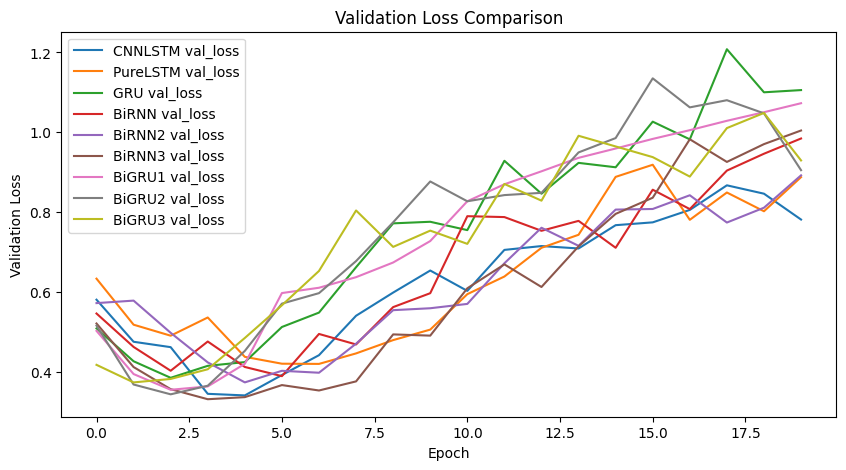

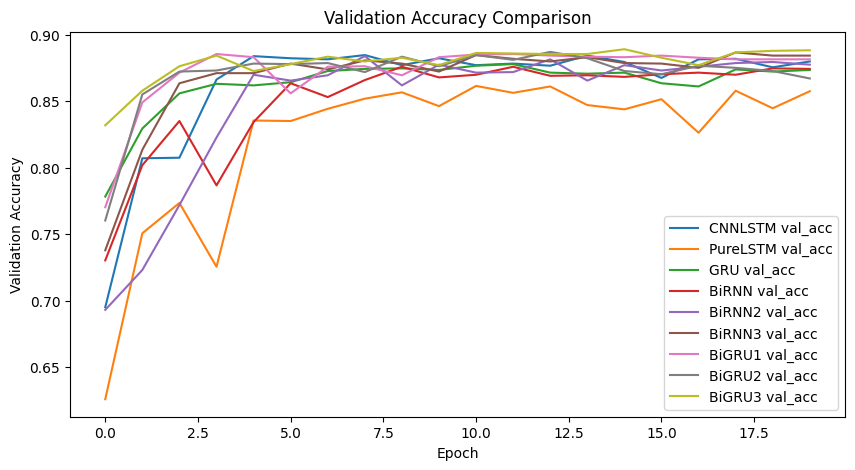

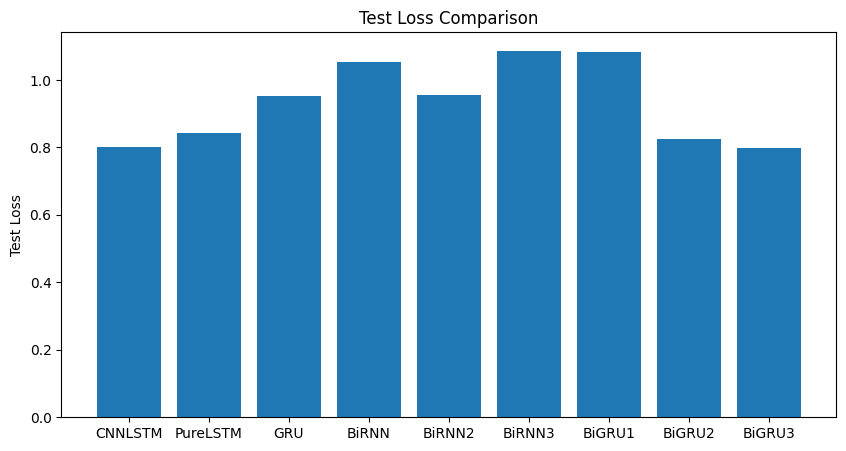

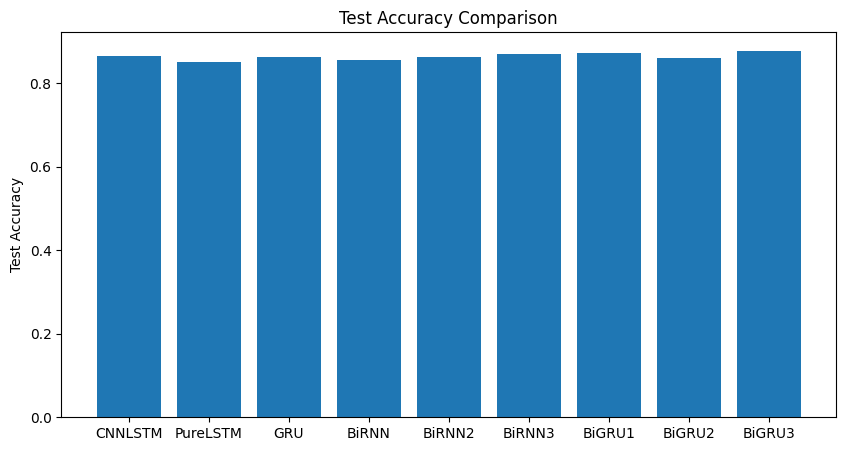

In [19]:
import matplotlib.pyplot as plt

# Validation Loss
plt.figure(figsize=(10,5))
for name, hist in all_histories.items():
    plt.plot(hist['val_loss'], label=f'{name} val_loss')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.title('Validation Loss Comparison')
plt.show()

# Validation Accuracy
plt.figure(figsize=(10,5))
for name, hist in all_histories.items():
    plt.plot(hist['val_accuracy'], label=f'{name} val_acc')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.title('Validation Accuracy Comparison')
plt.show()

# Test Loss and Accuracy (bar plot)
model_names = list(all_histories.keys())
test_losses = [all_histories[name]['test_loss'] for name in model_names]
test_accuracies = [all_histories[name]['test_accuracy'] for name in model_names]

plt.figure(figsize=(10,5))
plt.bar(model_names, test_losses)
plt.ylabel('Test Loss')
plt.title('Test Loss Comparison')
plt.show()

plt.figure(figsize=(10,5))
plt.bar(model_names, test_accuracies)
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy Comparison')
plt.show()

In [20]:
all_histories

{'CNNLSTM': {'train_loss': [0.6144842730665748,
   0.48977812057869,
   0.37030972582711413,
   0.24035899165425112,
   0.15822732833806763,
   0.09921112164209428,
   0.06477293326646429,
   0.039006114364548754,
   0.02652540383380917,
   0.020734993497171672,
   0.01278585156639813,
   0.014795093215112005,
   0.013990815038348293,
   0.010070141110356251,
   0.009685370493178363,
   0.012256776630258835,
   0.005180816911371783,
   0.0011667195870472824,
   0.004222865768362929,
   0.003592820393764255],
  'val_loss': [0.5807920090854168,
   0.4754332065582275,
   0.46193557754158976,
   0.3450720522552729,
   0.34110411871224644,
   0.39212569370865824,
   0.44185162503272296,
   0.5405796699225902,
   0.598627670109272,
   0.6538541775196791,
   0.6028612606227398,
   0.70548415184021,
   0.7150916419923306,
   0.7090847760438919,
   0.7673847354948521,
   0.7744579739868641,
   0.8056217491626739,
   0.8672018513083458,
   0.8462286785244941,
   0.7814806915819645],
  'val_accur

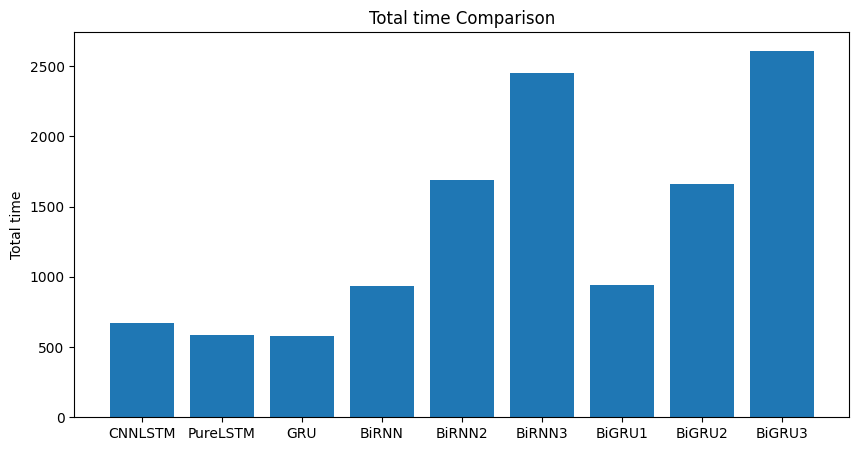

In [22]:
# Test Loss and Accuracy (bar plot)
model_names = list(all_histories.keys())
test_times = [all_histories[name]['total_time'] for name in model_names]


plt.figure(figsize=(10,5))
plt.bar(model_names, test_times)
plt.ylabel('Total time')
plt.title('Total time Comparison')
plt.show()